# K-Means Clustering

K-Means Clustering is an unsupervised learning algorithm to cluster data based on their similarity. Unsupervised learning means that there is no outcome to be predicted, and the algorithm just tries to find **intrinsic** patterns in the **unlabelled** data. 

A simple conception of what the optimal clustering looks like:

* The "cluster center" is the arithmetic mean of all the points belonging to the cluster.

* Each point is closer to its own cluster center than to other cluster centers.

## Import Libraries

In [1]:
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Synthetic Gaussian Data

First, let's generate a two-dimensional dataset containing four distinct blobs. To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

(-4, 4)

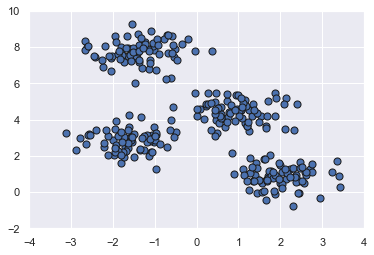

In [2]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50, edgecolor = 'k');
plt.ylim([-2,10])
plt.xlim([-4,4])

## Clustering

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_preds = kmeans.predict(X)
print(y_preds)

[1 0 3 0 1 1 2 3 0 0 2 0 3 0 1 3 3 1 2 2 1 1 3 2 2 3 1 3 2 3 0 0 3 0 0 0 0
 0 2 1 3 2 3 3 2 2 0 2 0 1 2 1 0 1 1 2 0 2 0 1 0 3 0 2 2 2 0 1 0 2 3 2 0 2
 2 0 2 3 1 0 1 3 1 1 0 3 1 3 0 0 3 1 0 2 2 3 1 1 3 2 0 1 0 1 3 1 1 3 0 3 2
 2 1 0 1 3 0 1 1 3 2 1 2 1 1 1 1 2 1 2 0 2 2 1 0 2 2 0 3 0 0 2 3 2 3 2 0 3
 0 0 0 3 0 3 1 2 0 2 1 3 0 3 3 1 3 2 2 3 1 3 3 0 1 3 2 0 1 1 3 2 1 3 2 2 3
 3 3 3 1 0 3 2 3 3 2 2 2 3 2 0 3 2 1 2 3 0 2 0 3 0 3 2 3 3 0 2 2 1 1 3 0 1
 1 2 1 2 3 0 0 3 3 0 3 1 2 3 1 2 0 2 1 3 1 0 0 0 0 2 2 0 3 2 1 3 2 2 2 1 1
 0 3 3 2 1 0 2 3 0 3 1 1 2 2 3 1 1 1 3 0 0 1 1 3 1 1 1 0 2 0 3 1 1 0 0 0 1
 1 3 0 2]


(-4, 4)

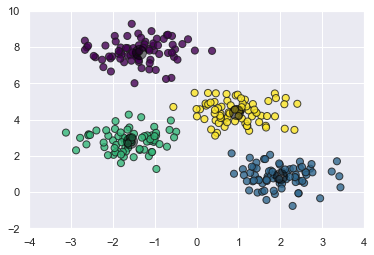

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y_preds, s=50, cmap='viridis',
            edgecolor = 'k',alpha=0.8)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.ylim([-2,10])
plt.xlim([-4,4])

## K-Means Algorithm: Expectation–Maximization

In K-means clustering, we specify the number of clusters we want the data to be grouped into, and iteratively update the centroids of clusters:

1. Guess some cluster centers
2. Repeat until converged
 * **E-step**: assign data points to the cluster whose centroid is closest. 
 * **M-step**: calculate new centroid of each cluster by averaging the associated data points. 

The two steps above are repeated till the total within cluster variation cannot be reduced any further (some cost function is minimized). The total within cluster variation is calculated as the sum of the euclidean distance between the data points and their respective cluster centroids:

$$
\min_{\mathbf{c}_1, \dots, \mathbf{c}_K} \; \sum_{i=1}^n \; \min_{1\leq k\leq K} \|\mathbf{x}_i - \mathbf{c}_k\|^2
$$

<img src='EM.png' width='1000'>

The K-Means algorithm is simple enough that we can write it in a few lines of code. The following is a very basic implementation:

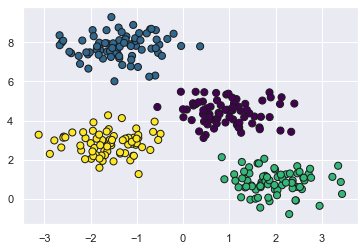

In [7]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        #  Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        #  Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis', edgecolor='k');

### Caveats of EM Algorithm

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved

Although the EM procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

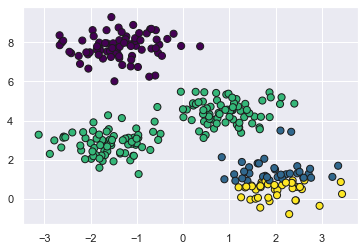

In [8]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis', edgecolor = 'k');

The EM algorithm has converged, but has not converged to a globally optimal solution. So it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand

Another common challenge with k-means is that it can not learn the number of clusters from the data. For example, EM can find the best 6 clusters:

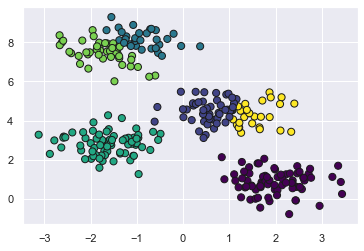

In [9]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis',edgecolor='k');

**Elbow Method** to find the optimal number of clusters:

* run EM algorithm over a loop for an increasing number of clusters $K$

* plot the within-cluster variance vs. $K$

* select the $K$ value at the 'elbow', i.e., the point after which within-cluster variance decreasing slowly

Text(0.5, 1.0, 'Elbow Method')

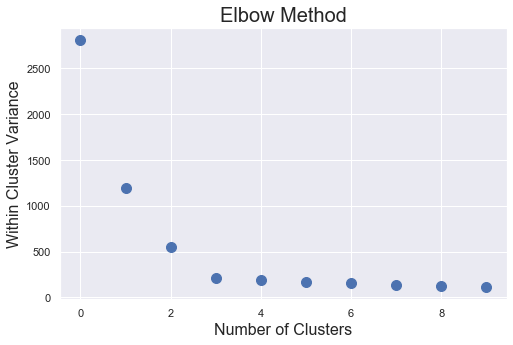

In [10]:
loss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k).fit(X)
    loss.append(kmeans.inertia_) 
    # Sum of squared distances of samples to closest center.
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(loss,'bo', markersize = 10)
ax.set_xlabel('Number of Clusters', fontsize= 16)
ax.set_ylabel('Within Cluster Variance', fontsize= 16)
ax.set_title('Elbow Method',  fontsize= 20)

### K-means is limited to linear cluster boundaries

The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries like two-moon data in the following:

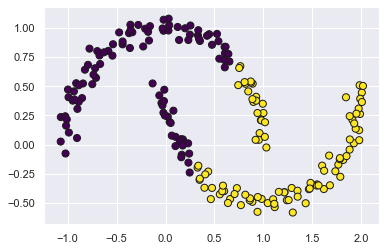

In [11]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)


labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, edgecolor = 'k',
            s=50, cmap='viridis');

#### K-means can be slow for large numbers of samples
Because each iteration of K-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. We can just use a subset of the data to update the cluster centers at each step. This gives the **mini-batch** version of K-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`. The interface for this is the same as for standard `KMeans`.

## Iris Data

It is **very important to note, we actually have the labels for this data set, but we will NOT use them for the K-means clustering algorithm.**

In [13]:
iris = sns.load_dataset('iris')
iris.head()
# iris.keys()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [14]:
# data points to cluster
data = iris.drop('species',axis=1) 
data.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


**Find true clusters given by the label (will not be used in K-means algorithm)**

In [16]:
true_cluster = iris['species']
true_cluster.head()

0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: species, dtype: object

In [17]:
# map string labels to numerical ones
true_cluster = true_cluster.replace({'setosa': 1, 'versicolor': 2, 'virginica':3})
true_cluster.head()

0    1
1    1
2    1
3    1
4    1
Name: species, dtype: int64

In [18]:
kmeans = KMeans(n_clusters=3)

In [19]:
clusters = kmeans.fit_predict(data)

In [20]:
kmeans.cluster_centers_

array([[5.006     , 3.428     , 1.462     , 0.246     ],
       [5.9016129 , 2.7483871 , 4.39354839, 1.43387097],
       [6.85      , 3.07368421, 5.74210526, 2.07105263]])

In [21]:
# cluster membership/label by kmeans
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1], dtype=int32)

In [22]:
# true cluster membership
true_cluster

0      1
1      1
2      1
3      1
4      1
      ..
145    3
146    3
147    3
148    3
149    3
Name: species, Length: 150, dtype: int64

**Compare the K-means result with groud-truth. Create 2-D sacttering plot on sepal length vs. sepal width**

(Text(0.5, 0, 'sepal length'), Text(0, 0.5, 'sepal width'))

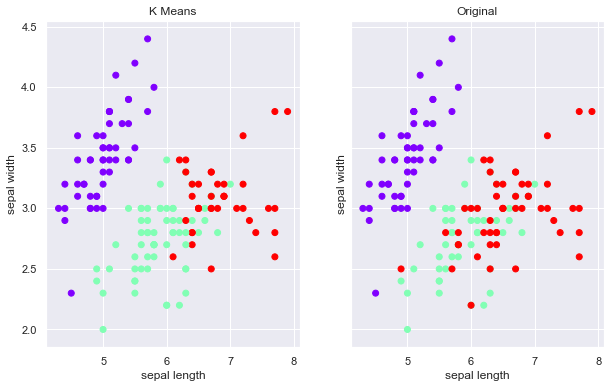

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
ax1.set_title('K Means')
ax1.scatter(data['sepal_length'],data['sepal_width'],c=kmeans.labels_,cmap='rainbow')
ax1.set_xlabel('sepal length'), ax1.set_ylabel('sepal width')
ax2.set_title("Original")
ax2.scatter(data['sepal_length'],data['sepal_width'],c=true_cluster,cmap='rainbow')
ax2.set_xlabel('sepal length'), ax2.set_ylabel('sepal width')

**Note that colors are meaningless in reference between the two plots above.**

Because K-means knows nothing about the identity of the cluster, the labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:

In [26]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(true_cluster[mask])[0]

(Text(0.5, 0, 'sepal length'), Text(0, 0.5, 'sepal width'))

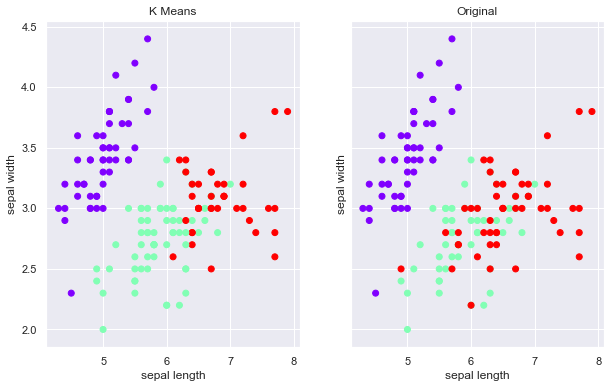

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
ax1.set_title('K Means')
ax1.scatter(data['sepal_length'],data['sepal_width'],c=labels,cmap='rainbow')
ax1.set_xlabel('sepal length'), ax1.set_ylabel('sepal width')
ax2.set_title("Original")
ax2.scatter(data['sepal_length'],data['sepal_width'],c=true_cluster,cmap='rainbow')
ax2.set_xlabel('sepal length'), ax2.set_ylabel('sepal width')

Now we can check how accurate our unsupervised clustering was in finding similar iris:

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(true_cluster, labels)

0.8933333333333333

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_cluster, labels)

array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0, 14, 36]])

## Color compression

One interesting application of clustering is in color compression within images. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn datasets module. You'll need to have the pillow Python package installed).

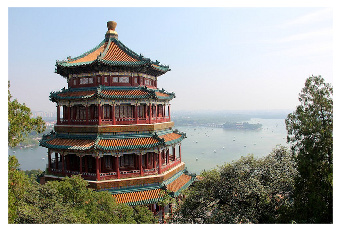

In [30]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
img = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(img);

The image itself is stored in a three-dimensional array of size (height, width, RGB), containing red/blue/green contributions as integers from 0 to 255:

In [27]:
img.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to `[n_samples x n_features]`, and rescale the colors so that they lie between 0 and 1:

In [31]:
data = img / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels:

In [32]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

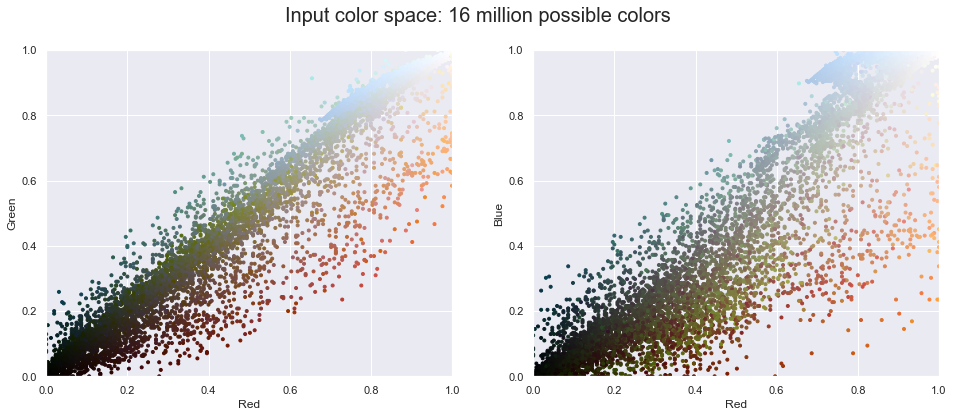

In [33]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now we reduce these 16 million colors to just 16 colors, using a K-means clustering across the pixel space. Because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard K-means algorithm:

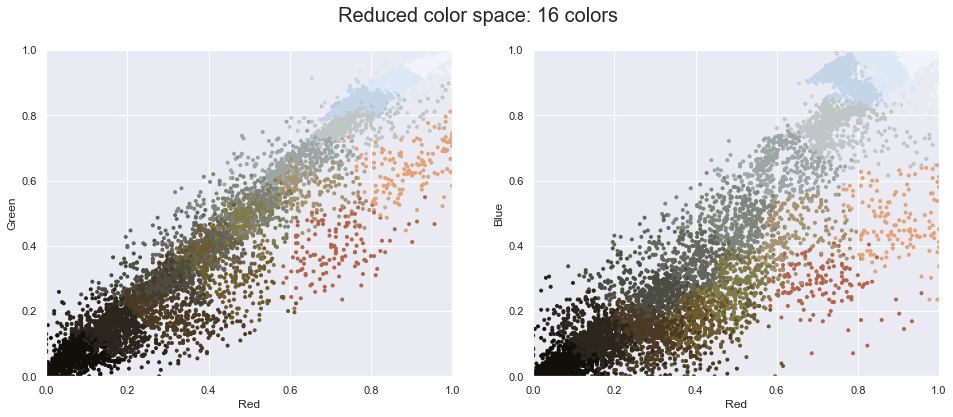

In [35]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
clusters = kmeans.predict(data) # Predict the closest cluster each sample in data belongs to.
new_colors = kmeans.cluster_centers_[clusters] 

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center.

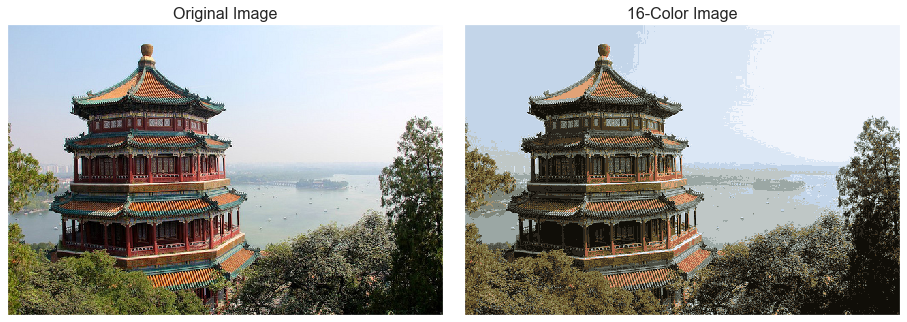

In [36]:
img_recolored = new_colors.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(img)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(img_recolored)
ax[1].set_title('16-Color Image', size=16);

Some detail is lost, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million.